In [1]:
from sympy import *
init_printing()

from IPython.display import display

## Averaged Lagrangian

In [2]:
z = Symbol(r"z", real=True)
t = Symbol(r"t", real=True)

In [3]:
A = [
    Function(r"A_{1}", real=True)(z), 
    Function(r"A_{2}", real=True)(z)
]
sigma = [
    Function(r"\sigma_{1}", real=True)(z), 
    Function(r"\sigma_{2}", real=True)(z)
]
t0 = [
    Function(r"t_{1}", real=True)(z),
    Function(r"t_{2}", real=True)(z)
]
Omega = [
    Function(r"\Omega_{1}", real=True)(z),
    Function(r"\Omega_{2}", real=True)(z)
]
phi = [
    Function(r"\phi_{1}", real=True)(z),
    Function(r"\phi_{2}", real=True)(z)
]

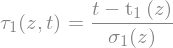

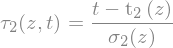

In [4]:
tau = [
    Function(r"\tau_{1}", real=True)(z, t),
    Function(r"\tau_{2}", real=True)(z, t)
]
tau_expr = [
    (t - t0[0]) / sigma[0],
    (t - t0[1]) / sigma[1]
]
S = Function(r"S", real=True)

# Just to print the definitions
_tau_eqs = [
    Eq(lhs, rhs) 
    for lhs, rhs in zip(tau, tau_expr)
]
display(*_tau_eqs)

In [5]:
U = [
    A[0] * S(tau[0]) * exp(-I * Omega[0] * t + I * phi[0]),
    A[1] * S(tau[1]) * exp(-I * Omega[1] * t + I * phi[1])
]

display(*U)

In [6]:
beta = [
    Symbol(r"\beta_{2}(\omega_{1})"),
    Symbol(r"\beta_{2}(\omega_{2})")
]

gamma = [
    Symbol(r"\gamma(\omega_{1})"),
    Symbol(r"\gamma(\omega_{2})")
]

def single_particle_lagrangian(u, n):
    return (
        I/2 * (u.diff(z) * u.conjugate() - u.conjugate().diff(z) * u) +
        Rational(1, 2) * beta[n] * u.diff(t) * u.conjugate().diff(t) +
        Rational(1, 2) * gamma[n]**2 * u**2 * u.conjugate()**2)

def interaction_lagrangian(u1, u2):
    return 2 * gamma[0] * gamma[1] * u1 * u1.conjugate() * u2 * u2.conjugate()

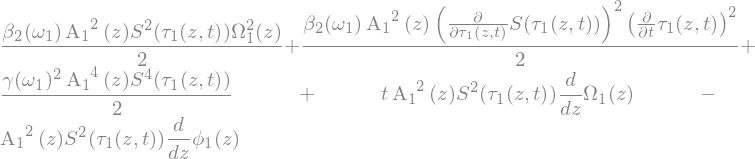

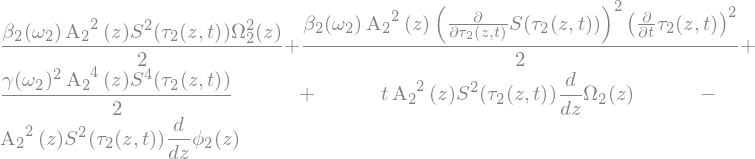

In [7]:
L_sp = [
    single_particle_lagrangian(U[n], n).expand()
    for n in range(2)
]

display(*L_sp)

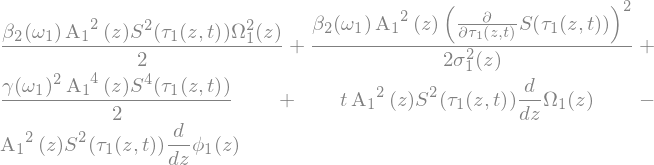

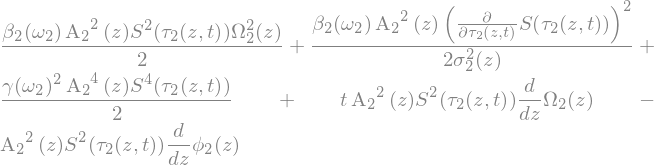

In [10]:
def replace_tau_diff(expr, n):
    return expr.subs(tau[n].diff(t), tau_expr[n].diff(t))

L_sp = [
    replace_tau_diff(L_sp[n], n)
    for n in range(2)
]

display(*L_sp)

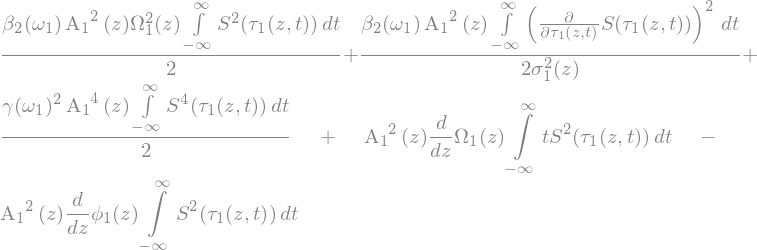

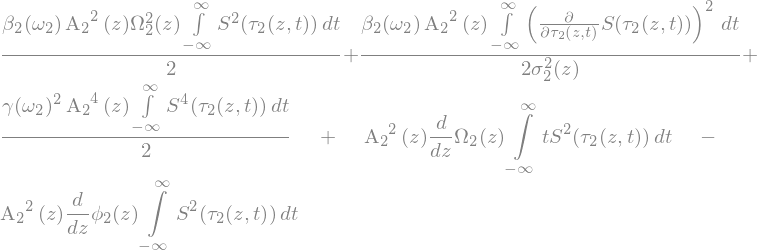

In [11]:
L_sp_avg = [
    integrate(L_sp[n], (t, -oo, +oo)).doit().expand()
    for n in range(0, 2)
]

display(*L_sp_avg)

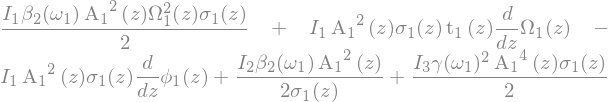

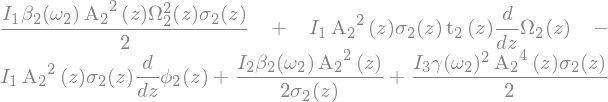

In [12]:
I1 = Symbol("I_{1}", real=True)
I2 = Symbol("I_{2}", real=True)
I3 = Symbol("I_{3}", real=True)

def replace_integrals(expr, n):
    I1_expr = Eq(sigma[n] * I1, Integral(S(tau[n])**2, (t, -oo, +oo)))
    I2_expr = Eq(sigma[n] * I2, Integral(S(tau[n]).diff(tau[n])**2, (t, -oo, +oo)))
    I3_expr = Eq(sigma[n] * I3, Integral(S(tau[n])**4, (t, -oo, +oo)))
    return (
        expr.subs(I1_expr.rhs, I1_expr.lhs)
            .subs(
                Integral(t * S(tau[n])**2, (t, -oo, +oo)), 
                sigma[n] * t0[n] * I1)
            .subs(I2_expr.rhs, I2_expr.lhs)
            .subs(I3_expr.rhs, I3_expr.lhs))

L_sp_avg = [
    replace_integrals(L_sp_avg[n], n)
    for n in range(2)
]

display(*L_sp_avg)

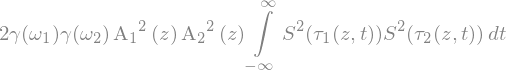

In [17]:
L_int = interaction_lagrangian(*U)
L_int = L_int.simplify()

display(L_int)

# L_int_avg = integrate(L_int, (t, -oo, +oo))
# ^^^ this is way too slow :(
L_int_avg = (
    2 * gamma[0] * gamma[1] 
      * A[0]**2 * A[1]**2 
      * Integral(S(tau[0])**2 * S(tau[1])**2, (t, -oo, +oo)))

display(L_int_avg)

I_int = Function("I_{int}")(t0[0], t0[1], sigma[0], sigma[1])
L_int_avg = L_int_avg.subs(
    Integral(S(tau[0])**2 * S(tau[1])**2, (t, -oo, +oo)), 
    I_int)

display(L_int_avg)

Due to homogeneity in $t$, we can assume $I_{int}(t_{1} - t_{2}, \sigma_{1}, \sigma_{2})$

In [19]:
I_int_hom = Function("I_{int}")(t0[0] - t0[1], sigma[0], sigma[1])
L_int_avg = L_int_avg.subs(I_int, I_int_hom)

display(L_int_avg)

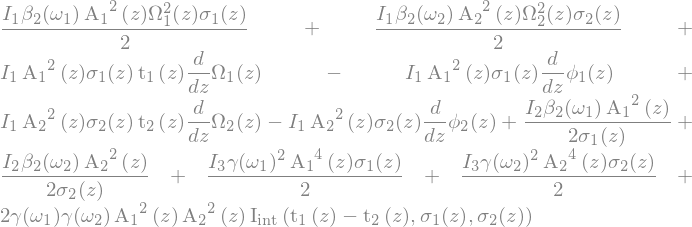

In [20]:
L_avg = L_sp_avg[0] + L_sp_avg[1] + L_int_avg

display(L_avg)

## Equations of motion

In [21]:
def variation(expr, q):
    p = Symbol("p")
    return expr.diff(q) - expr.subs(q.diff(z), p).diff(p).diff(z)

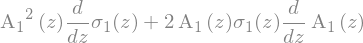

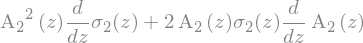

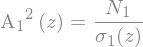

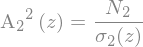

In [22]:
for n in range(2):
    eq = (variation(L_avg, phi[n]) / I1).expand()
    display(eq)
    
N = [Symbol("N_{1}"), Symbol("N_{2}")]

N_expr = [
    Eq(N[n], sigma[n] * A[n]**2)
    for n in range(2)
]
display(*N_expr)

A_expr = [
    Eq(A[n]**2, N[n] / sigma[n])
    for n in range(2)
]
display(*A_expr)

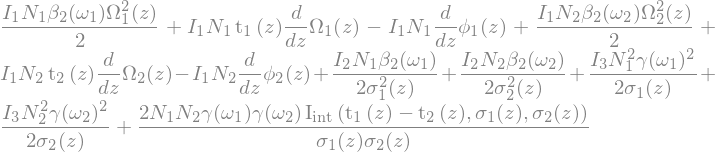

In [23]:
for n in range(2):
    L_avg = L_avg.subs(A_expr[n].lhs, A_expr[n].rhs)
    
display(L_avg)

In [ ]:
Eq_Omega = []

for n in range(2):
    eq = variation(L_avg, Omega[n])
    eq = eq / I1 / N[n]
    eq = eq.expand()
    
    lhs = t0[n].diff(z)
    rhs = solve(eq, lhs)[0]
    eq = Eq(lhs, rhs)
    
    Eq_Omega.append(eq)
    
display(*Eq_Omega)

In [ ]:
Eq_t0 = []

for n in range(2):
    eq = variation(L_avg, t0[n])
    eq = eq / I1 / N[n]
    eq = eq.expand()
    
    lhs = Omega[n].diff(z)
    rhs = solve(eq, lhs)[0]
    eq = Eq(lhs, rhs)
    
    Eq_t0.append(eq)
    
display(*Eq_t0)

In [ ]:
Eq_momentum_conservation = Eq(
    N[0] * Eq_t0[0].lhs + N[1] * Eq_t0[1].lhs,
    N[0] * Eq_t0[0].rhs + N[1] * Eq_t0[1].rhs)

display(Eq_momentum_conservation)

In [ ]:
Eq_sigma = []

for n in range(2):
    eq = variation(L_avg, sigma[n])
    eq = eq * sigma[n]**2 * sigma[1 - n]
    eq = eq.expand()
    Eq_sigma.append(Eq(eq, 0))
    
display(*Eq_sigma)

## Center of mass coordinates

In [ ]:
dt = Function(r"\Delta t")(z)
dt_expr = Eq(dt, t0[0] - t0[1])

tc = Function(r"t_{0}")(z)
tc_expr = Eq(tc, Rational(1, 2) * (t0[0] + t0[1]))

display(dt_expr, tc_expr)

In [ ]:
I_int_hom = I_int_hom.subs(t0[0] - t0[1], dt)
display(I_int_hom)

In [ ]:
Eq_dt = Eq(dt.diff(), Eq_Omega[0].rhs - Eq_Omega[1].rhs)
display(Eq_dt)

Eq_tc = Eq(tc.diff(), Rational(1, 2) * (Eq_Omega[0].rhs + Eq_Omega[1].rhs))
display(Eq_tc)

In [ ]:
Eq_t0 = [
    Eq_t0[n].subs(t0[0] - t0[1], dt)
    for n in range(2)
]
display(*Eq_t0)

In [ ]:
Eq_sigma = [
    Eq_sigma[n].subs(t0[0] - t0[1], dt)
    for n in range(2)
]
display(*Eq_sigma)

Essentially, we have an isolated system of equations

In [ ]:
display(Eq_dt)
display(*Eq_t0)
display(*Eq_sigma)

The last pair is essentially just a system of equations for $\sigma_{1}$ and $\sigma_{2}$ as functions of $\Delta t$.

## Gaussian pulses

In [ ]:
I_1_expr = integrate(exp(-2 * t**2), (t, -oo, +oo))
I_1_expr

In [ ]:
inner = exp(-(tau[0])**2)**2 * exp(-tau[1]**2)**2

for n in range(2):
    inner = inner.subs(tau[n], tau_expr[n])
    
inner = inner.simplify()
display(inner)

In [ ]:
power = - inner.args[0]
power = power.expand()
a_sq = power.coeff(t**2)
ab = power.coeff(t) / 2
c = (power - a_sq * t**2 - 2 * ab * t).simplify()

display(power)
display(a_sq, ab, c)

In [ ]:
a = sqrt(a_sq)
b = ab / a

fsq_power = a**2 * (t + b/a)**2 - b**2 + c
assert (fsq_power - power).simplify() == 0

In [ ]:
residue = - 2 * (t0[0] - t0[1])**2 / (sigma[0]**2 + sigma[1]**2)
assert (b**2 - c - residue).simplify() == 0

fsq_inner = exp(- a**2 * t**2) * exp(residue)
display(Eq(I_int_hom, Integral(fsq_inner, (t, -oo, +oo))))

In [ ]:
I_int_expr = Eq(I_int_hom, sqrt(pi) / a * exp(residue))
display(I_int_expr)

In [ ]:
I_int_expr = I_int_expr.subs(t0[0] - t0[1], dt)
display(I_int_expr)

## Small oscillations

In [ ]:
lhs = Eq_dt.lhs.diff(z)
rhs = Eq_dt.rhs.diff(z).subs(Eq_t0[0].lhs, Eq_t0[0].rhs).subs(Eq_t0[1].lhs, Eq_t0[1].rhs)


Eq_osc = Eq(lhs, rhs.simplify())
display(Eq_osc)

In [ ]:
sigma_dt = [
    Function(r"\sigma_{1}")(dt),
    Function(r"\sigma_{2}")(dt)
]

rhs = Eq_osc.rhs
for n in range(2):
    rhs = rhs.replace(sigma[n], sigma_dt[n])

Eq_osc = Eq(Eq_osc.lhs, rhs)
display(Eq_osc)

In [ ]:
Eq_osc.rhs.subs(I_int_hom, I_int_expr.rhs).diff(dt).doit().subs(dt, 0)

In [ ]:
I_int_expr.rhs.diff(dt, 2).subs(dt, 0)

In [ ]:
Eq_a = Eq_sigma[0].subs(I_int_hom, I_int_expr.rhs).doit().subs(dt, 0)
Eq_b = Eq_sigma[1].subs(I_int_hom, I_int_expr.rhs).doit().subs(dt, 0)

display(Eq_a, Eq_b)

In [ ]:
K_sq = (
    2 * gamma[0] * gamma[1] 
      * (beta[0] * N[0] + beta[1] * N[1])
      / I_1_expr / sigma[0] / sigma[1]
) * I_int_expr.rhs.diff(dt, 2).subs(dt, 0)

K_sq